In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout, LSTM

from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import joblib
import glob
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [3]:
def label2onehot(label: np.array) -> np.array:
    thresholds = [0.25, 0.75, 1.25, 1.75]

    categorical_labels = np.digitize(label, thresholds)

    one_hot_encoder = to_categorical(categorical_labels)
    
    return one_hot_encoder

In [4]:
def load_data() -> tuple:
    X = None
    y = None
    all_path = sorted(glob.glob('../data/input_data/*'))
    # count = 1
    for count, path in enumerate(all_path):
        print(f"{count}. {path.split('/')[-1].split('.')[0]}")
        data_loaded = joblib.load(path)
        if X is None:
            X = data_loaded['X']
            y = data_loaded['activate_score']
        else:
            X = np.concatenate((X, data_loaded['X']), axis=0)
            y = np.concatenate((y, data_loaded['activate_score']), axis=0)

        # if count == 0:
        #     break
        # count += 1
    
    y = y.reshape(-1, 1)
    y = label2onehot(y)
     
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)        
    
    # y_train = y_train.reshape(-1, 1)
    # y_test = y_test.reshape(-1, 1)
    
    # y_train = label2onehot(y_train)
    # y_test = label2onehot(y_test)
    
    # return X_train, X_test, y_train, y_test
    return X, y

In [5]:
# X_train, X_test, y_train, y_test = load_data()
X_train, y_train = load_data()

    
input_shape = X_train.shape[1:]

0. input_data\batch_0
1. input_data\batch_1
2. input_data\batch_2
3. input_data\batch_3
4. input_data\batch_4
5. input_data\batch_5
6. input_data\batch_6
7. input_data\batch_7
8. input_data\batch_8
9. input_data\batch_9


In [6]:
X_train[0].T

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
# print(f'X_train: {X_train.shape}; X_test: {X_test.shape}; y_train: {y_train.shape}; y_test: {y_test.shape}, input_shape{input_shape}')
print(f'X_train: {X_train.shape}; y_train: {y_train.shape}; input_shape{input_shape}')

X_train: (5000, 14868, 13); y_train: (5000, 5); input_shape(14868, 13)


In [8]:
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

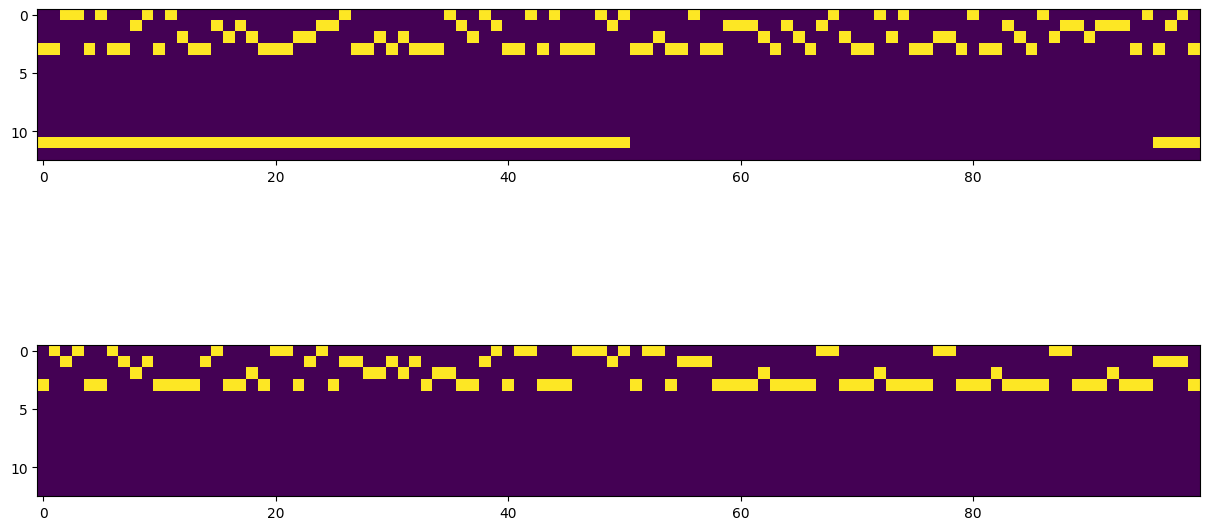

In [9]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.imshow(X_train[0][7318:7418].T)
plt.subplot(2, 1, 2)
plt.imshow(X_train[0][:100].T)

In [10]:
X_train[0].shape

(14868, 13)

In [11]:
def cnn_block(layer, filters_num: int, kernel_size: int, strides: int, padding: int, dropout_rate: float, name_index: int, pool_size: int, pool_strides: int, pool_padding: int):
    layer = Conv1D(
        filters=filters_num,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        activation='linear',
        kernel_initializer='VarianceScaling',
        bias_initializer='Zeros',
        name=f'conv_{name_index}'
    )(layer)
    
    layer = BatchNormalization(name=f'batch_{name_index}')(layer)
    layer = Activation(activation='relu', name=f'activation_{name_index}')(layer)
    layer = Dropout(rate=dropout_rate, name=f'dropout_{name_index}')(layer)
    layer = MaxPooling1D(pool_size=pool_size, strides=pool_strides, padding=pool_padding, name=f'max_pooling_{name_index}')(layer)
    
    return layer

In [14]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, dtype=float, name="data")
    # labels = tf.keras.layers.Input(name="label", shape=(None,))
    
    # layer = cnn_block(layer=inputs, filters_num=70, kernel_size=19, strides=5, padding='valid', dropout_rate=0, name_index=1, pool_size=3, pool_strides=3, pool_padding='valid')
    # layer = cnn_block(layer=layer, filters_num=46, kernel_size=11, strides=5, padding='valid', dropout_rate=0, name_index=2, pool_size=4, pool_strides=4, pool_padding='valid')
    # layer = cnn_block(layer=layer, filters_num=46, kernel_size=7, strides=5, padding='valid', dropout_rate=0, name_index=3, pool_size=4, pool_strides=4, pool_padding='valid')
    
    # layer = Flatten(name='flatten')(layer)
  
    layer = LSTM(128, return_sequences=True)(inputs)
    layer = LSTM(128)(layer)
    
    layer = Dense(units=32, activation='linear', kernel_initializer='VarianceScaling', bias_initializer='Zeros', name='dense1')(layer)
    layer = Activation(activation='relu', name=f'activation_{4}')(layer)
    layer = Dropout(0.3, name='dropout_4')(layer)
    layer = Dense(units=32, activation='linear', kernel_initializer='VarianceScaling', bias_initializer='Zeros', name='dense2')(layer)
    
    outputs = Dense(units=5, activation='softmax', kernel_initializer='VarianceScaling', bias_initializer='Zeros')(layer)
    
    model = Model(inputs=inputs, outputs=outputs, name='cnn_model')
    
    return model

In [15]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data (InputLayer)           [(None, 14868, 13)]       0         
                                                                 
 lstm_2 (LSTM)               (None, 14868, 128)        72704     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense1 (Dense)              (None, 32)                4128      
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense2 (Dense)              (None, 32)                10

In [16]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
now = datetime.now().strftime('%d-%m-%Y_%H-%M')

checkpoint_callback = ModelCheckpoint(filepath=f"../model/ModelCheckPoint/{now}/" + "model.{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.h5",
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      verbose=1)
tensorboard_callback = TensorBoard(log_dir=f"../model/TensorBoard/{now}/logs")

folder_logger_path = f"../model/CSVLogger/{now}"

if os.path.exists(folder_logger_path) and os.path.isdir(folder_logger_path):
    os.rmdir(folder_logger_path)
os.makedirs(folder_logger_path)

csv_logger_callback = CSVLogger(f"{folder_logger_path}/training.log")

In [18]:
model.fit(X_train, y_train, 
          epochs=20,
          validation_split=.2,  
          batch_size=32,
          callbacks=[checkpoint_callback,
                     tensorboard_callback,
                     csv_logger_callback]
          )
model.save(f"../model/FinalModel/{now}/model.h5")

Epoch 1/20


  1/125 [..............................] - ETA: 11:45:14 - loss: 1.6081 - accuracy: 0.3125

In [27]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 333ms/step


In [28]:
y_test

array([[0., 1., 0., 0., 0.]], dtype=float32)

In [29]:
y_pred

array([[0.20089799, 0.19670978, 0.1969538 , 0.20947286, 0.19596557]],
      dtype=float32)

In [19]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 42ms/step - loss: 0.9786 - accuracy: 0.0000e+00


[0.9785565733909607, 0.0]